<a href="https://colab.research.google.com/github/AlbertoRomanRamosRodriguez/Tesis-de-Grado/blob/main/APTOS_EYEPACS_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grading Diabetic Retinopath with APTOS and EYEPACS

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive,move
from google.colab import drive

import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
class KaggleJSONFile:
  def __init__(self, folder_path:str):
    self.__folder_location = folder_path
    self.__filename = 'kaggle.json'
    self.__destination_path = '/root/.kaggle'

  def setup(self):
    p_orig = os.path.join(self.__folder_location, self.__filename)
    p_dest = os.path.join(self.__destination_path, self.__filename)

    os.mkdir(self.__destination_path)
    copy(p_orig, p_dest)

    !chmod 600 {p_dest}


In [ ]:
k = KaggleJSONFile('/gdrive/MyDrive/Kaggle_keys')
k.setup()

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

100% 9.51G/9.51G [05:10<00:00, 39.5MB/s]
100% 9.51G/9.51G [05:10<00:00, 32.9MB/s]
100% 6.04G/6.04G [03:31<00:00, 25.1MB/s]
100% 6.04G/6.04G [03:31<00:00, 30.7MB/s]


In [ ]:
zipfiles = [f for f in os.listdir('/content') if '.zip' in f]

def unpack(filename:str):
  f = os.path.join('/content', filename)

  unpack_archive(
      filename = f,
      extract_dir='/content'
  )

  return os.path.join('/content',filename.split('.')[0])

dataset_dirs = [unpack(z) for z in zipfiles]

In [ ]:
train_csv_files = [f for f in os.listdir('/content') if '.csv' in f and 'train' in f]
dataframes = [pd.read_csv(csv) for csv in train_csv_files]

name_mappings = {
    'id_code': 'image',
    'diagnosis': 'level'
}


for d, extension in zip(dataframes, ['.jpeg', '.png']):
  d.rename(columns=name_mappings, inplace=True)
  d['image'] = d['image']+ extension
  display(d.head())

classes = range(5)
orig_ds = pd.concat(dataframes)
orig_ds.reset_index(inplace=True)
orig_ds.iloc[0,:]

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


,image,level
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


index               0
image    10_left.jpeg
level               0
Name: 0, dtype: object

level
0    27607
1     2808
2     6287
3     1065
4     1003
Name: image, dtype: int64

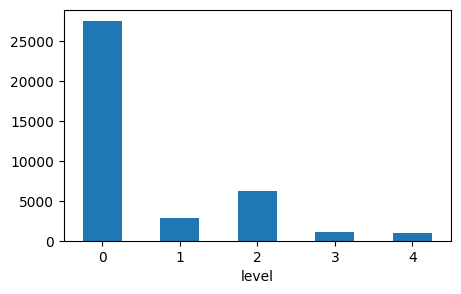

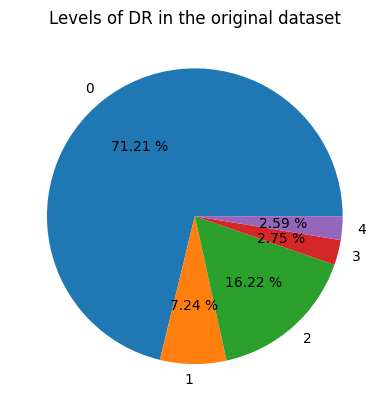

In [ ]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

DB_PATH = './DB'
reset_path(DB_PATH)

display(orig_ds.groupby('level')['image'].count())

dfp = orig_ds.pivot_table(
    index='level',
    aggfunc='size'
)
dfp.plot(
    kind='bar',
    figsize=(5,3),
    rot=0
)
plt.show()

classes = 5
plt.pie([orig_ds.loc[orig_ds['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the original dataset")
img_path = os.path.sep.join([DB_PATH, 'distribution.png'])
plt.savefig(img_path)
plt.show()

level
0    1000
1    1000
2    1000
3    1000
4    1000
Name: image, dtype: int64

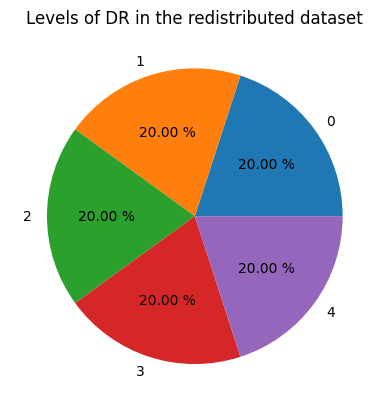

In [ ]:
dataset = orig_ds.groupby(['level']).sample(1000)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the redistributed dataset")
plt.show()

In [ ]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

display(train_df.groupby(['level'])['image'].count())
display(train_df.head())
display(val_df.groupby(['level'])['image'].count())
display(val_df.head())
display(test_df.groupby(['level'])['image'].count())
display(test_df.head())

level
0    784
1    810
2    808
3    790
4    808
Name: image, dtype: int64

,image,level
29903,37834_right.jpeg,4
34267,43339_left.jpeg,4
19896,25102_left.jpeg,0
2714,3379_right.jpeg,3
36654,6cd606dc52e9.png,4


level
0    108
1     96
2     96
3    103
4     97
Name: image, dtype: int64

,image,level
8274,10374_left.jpeg,2
23922,30226_left.jpeg,3
3932,4937_left.jpeg,2
6940,8711_left.jpeg,1
23529,29744_right.jpeg,0


level
0    108
1     94
2     96
3    107
4     95
Name: image, dtype: int64

,image,level
37104,8c0d05233238.png,3
19768,24955_left.jpeg,0
38043,cb75210abebe.png,2
10700,13490_right.jpeg,1
28105,35609_right.jpeg,3


In [ ]:
path_dict = {p:os.listdir(p)
              for p in ['/content/train_images', '/content/eyepacs_preprocess/eyepacs_preprocess']}
path_dict

{'/content/train_images': ['2fdfb80ea53c.png',
  '499c8df39222.png',
  '0423237770a7.png',
  '70f5caf5f305.png',
  'cd01f4f83336.png',
  '974c7d7b9c64.png',
  '99e8bf998285.png',
  'f6f433f3306f.png',
  '1eee55494271.png',
  'a3802934bad7.png',
  '838b3e4d0bb4.png',
  '0cb6b898389f.png',
  'aa60813e1a8d.png',
  '349f3c0ac83e.png',
  '3428230bf1bd.png',
  '7a42443ed106.png',
  'c76664770c07.png',
  '95e732e043a1.png',
  '5d024177e214.png',
  'f9aa35187bf3.png',
  '7c6594b50690.png',
  'eeb231c3ef1f.png',
  '1e8c31e29dd3.png',
  'fa59221cf464.png',
  '15e24b73d4a7.png',
  '2532613a584a.png',
  '99c6a123ed6a.png',
  '50a2aef380c8.png',
  'd516f77d4516.png',
  '9f935fb38440.png',
  '6194e0fff071.png',
  '83038ca49b6d.png',
  '354b8911d6ed.png',
  '92889b863ae6.png',
  '94f9ecf4b8d2.png',
  '81704925f759.png',
  '75a071608ea6.png',
  'a125377fb985.png',
  '6c6505a0c637.png',
  '80dbeb0fdc75.png',
  '22d843b2bbd1.png',
  '247e98aba610.png',
  'df9cb3729eb1.png',
  '5cde55f745af.png',
  'c622

In [ ]:
def clahe_image(path:str):
    # Load the image
    img = cv2.imread(path)
    # mask = cv2.imread('mask.png', 0)

    # Extract the green plane
    green_plane = img[:, :, 1]

    # Define the FA-CLAHE algorithm
    faclahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))

    # Apply the FA-CLAHE algorithm to the green plane
    faclahe_img = faclahe.apply(green_plane)

    # masked_img = cv2.bitwise_and(faclahe_img, faclahe_img, mask=mask)

    cv2.imwrite(path, faclahe_img)

In [ ]:
splits = [
    (train_df, 'train'),
    (val_df, 'val'),
    (test_df, 'test')
]

for df, set_path in splits:
  df['level'] = df['level'].astype('str')
  ds_dict = df.to_dict(orient='index')
  set_path = os.path.join(DB_PATH, set_path)
  if not os.path.exists(set_path):
    os.mkdir(set_path)

  for datapoint in ds_dict.values():
    orig_path = ''
    print(datapoint['image'])
    for p, imgs in path_dict.items():
        orig_path = os.path.join(p, datapoint['image']) if datapoint['image'] in imgs else orig_path

    dest_path = os.path.join(set_path, datapoint['level'])
    
    if not os.path.exists(dest_path):
      os.mkdir(dest_path)
    
    dest_path = os.path.join(dest_path, datapoint['image'])

    clahe_image(orig_path)
    move(orig_path, dest_path)

37834_right.jpeg
43339_left.jpeg
25102_left.jpeg
3379_right.jpeg
6cd606dc52e9.png
19635_right.jpeg
13819_right.jpeg
25697_right.jpeg
11040_left.jpeg
13125_right.jpeg
4df6a81b476e.png
27943_left.jpeg
1420_left.jpeg
29976_right.jpeg
16748_right.jpeg
3356_right.jpeg
19229_right.jpeg
8681_right.jpeg
0f96c358a250.png
f5e6226bd2e0.png
cb547e723a16.png
37808_right.jpeg
1393_left.jpeg
33884_left.jpeg
0eb52045349f.png
9404_right.jpeg
5990_left.jpeg
4a7dc013e802.png
19588_right.jpeg
38274_left.jpeg
41548_right.jpeg
07122e268a1d.png
42683_left.jpeg
35124_left.jpeg
3287_right.jpeg
10579_left.jpeg
5569_left.jpeg
34611_right.jpeg
38072_right.jpeg
178_right.jpeg
43158_left.jpeg
27259_left.jpeg
1636_left.jpeg
38997_left.jpeg
29038_left.jpeg
41059_left.jpeg
21507_right.jpeg
803_right.jpeg
43042_left.jpeg
17135_right.jpeg
15944_left.jpeg
7560_left.jpeg
ac5b5dddf91b.png
14880_left.jpeg
43486_left.jpeg
18622_left.jpeg
df4aec4a0eaf.png
1639_left.jpeg
29788_left.jpeg
17452_left.jpeg
16955_right.jpeg
2a08ed6

Using device cuda:0


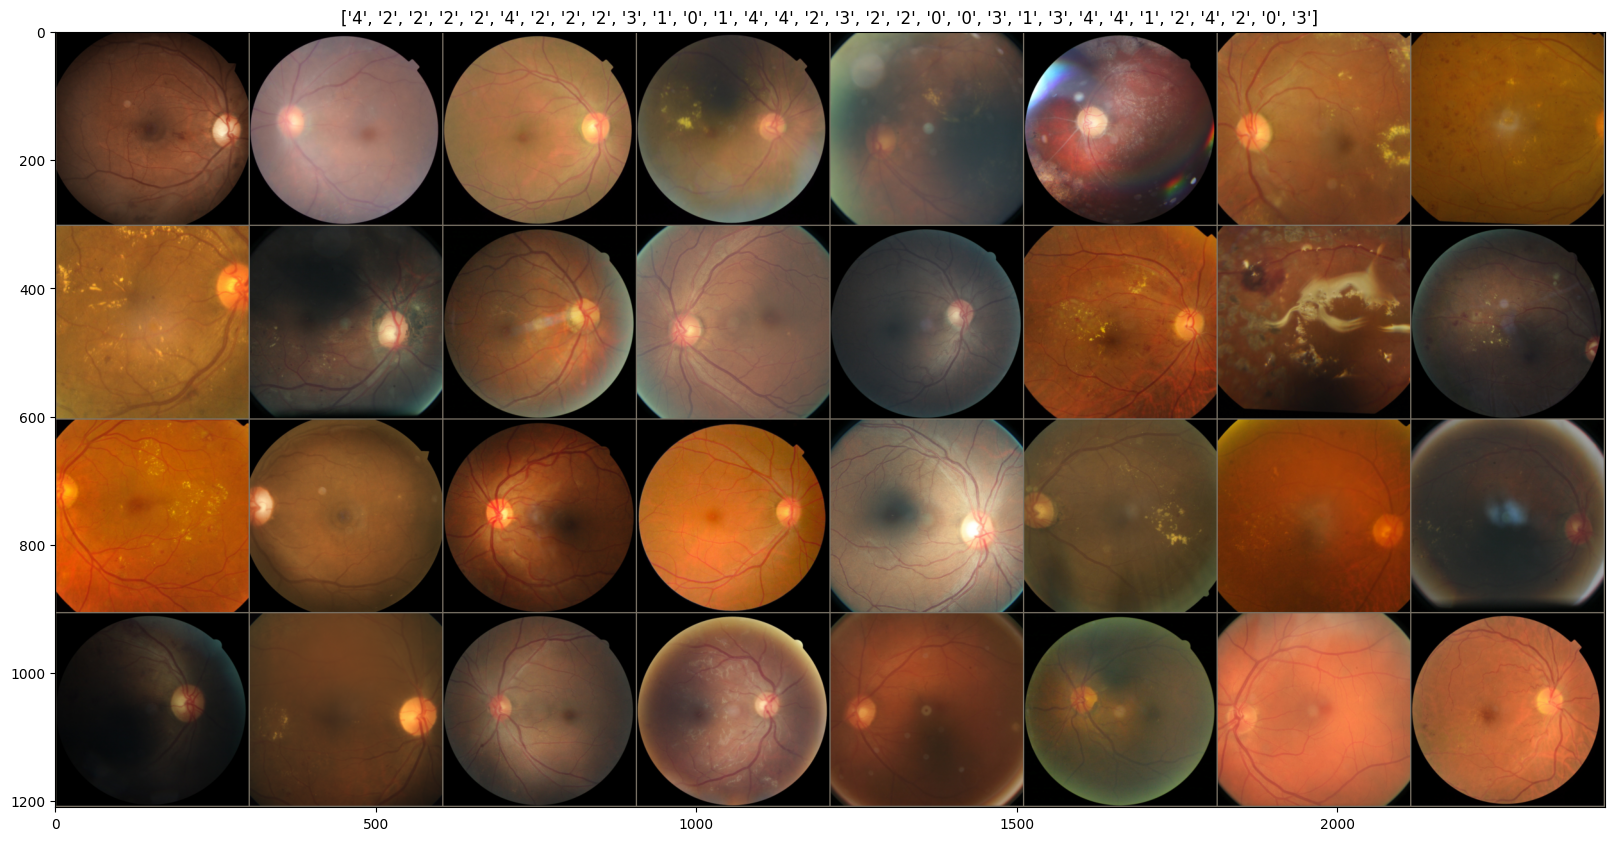

In [ ]:
# MobileNet Grading of Diabetic Retinopathy in PyTorch
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode
## Load Data

IM_SIZE = 300
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=False, num_workers=2)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'Using device {device}')

def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))
## Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, starting_loss = float('inf')):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = starting_loss
    best_acc = 0.0 

    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs+1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Update best validation loss and model weights
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best model found with validation loss: {best_loss:.4f}')

            print()

    except KeyboardInterrupt:
        pass

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_loss:.4f} | Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return (best_loss, model)




def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
!pip install torchcontrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')
model_weights = models.MobileNet_V3_Large_Weights.DEFAULT

model_ft = models.mobilenet_v3_large(weights=model_weights)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.RMSprop(
    model_ft.parameters(), 
    lr=0.001, 
    weight_decay=1e-5, 
    momentum=0.9
)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.001)


In [ ]:
warmup_epochs = 20
training_epochs = warmup_epochs * 3
FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')

print(f"Training on device {device}")
for param in model_ft.features.parameters():
    param.requires_grad = False


best_warmup_loss, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs=warmup_epochs
)

for param in model_ft.features.parameters():
    param.requires_grad = True

_, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs=training_epochs,
    starting_point = best_warmup_loss
)

MobileNet_V3_Large_Weights.IMAGENET1K_V2_20_60_Grading_22_Apr_23_15_56
Training on device cuda:0
Epoch 1/21
----------
train Loss: 4.5112 Acc: 0.3550
val Loss: 1.6915 Acc: 0.3780
New best model found with validation loss: 1.6915

Epoch 2/21
----------
train Loss: 1.2936 Acc: 0.4507
val Loss: 1.4060 Acc: 0.4360
New best model found with validation loss: 1.4060

Epoch 3/21
----------
train Loss: 1.2424 Acc: 0.4798
val Loss: 1.3501 Acc: 0.4300
New best model found with validation loss: 1.3501

Epoch 4/21
----------
train Loss: 1.1541 Acc: 0.5020
val Loss: 1.3316 Acc: 0.4420
New best model found with validation loss: 1.3316

Epoch 5/21
----------
train Loss: 1.1557 Acc: 0.4960
val Loss: 1.3229 Acc: 0.4440
New best model found with validation loss: 1.3229

Epoch 6/21
----------
train Loss: 1.1411 Acc: 0.5078
val Loss: 1.3164 Acc: 0.4520
New best model found with validation loss: 1.3164

Epoch 7/21
----------
train Loss: 1.1414 Acc: 0.5125
val Loss: 1.3159 Acc: 0.4520
New best model found wi

In [ ]:
if not os.path.exists('models'):
  os.mkdir('models')

MODEL_PATH = os.path.sep.join(['models', f'{FILENAME}.pt'])
torch.save(model_ft.state_dict(), MODEL_PATH)

In [ ]:
visualize_model(model_ft)
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

device = torch.device("cpu")
model_ft = model_ft.to(device)
model_ft.eval()

for inputs, labels in test_dataloader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")
print("[INFO] Building Matrix")
# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

if not os.path.exists('output'):
  os.mkdir('output')
OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)

In [ ]:
import shutil

shutil.copy(MODEL_PATH, '/gdrive/MyDrive/Models')